
# Supply Chain Analytics: Assignment 3 

|Nr|**Name**|**Student ID**|**Email**|
|--|--------|--------------|---------|
|1.|  Katja Tophoff      |     13378678         |     katja.tophoff@gmail.com   |
|2.|     Nicky Trijbits   |       12857815       |      ntrijbits@gmail.com   |
|3.|    Albin Lindqvist    |       13986236       |    albin.lindqvist@hotmail.se     |

## Base-Stock Policies 

In [1]:
# set parameters
# Time horizon
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt


T = 10
# Cost
c = 1.0
# Revenue from selling a unit of product
h = 1.0
# Penalty for not meeting demand
p = 10.0
# Discount factor
gamma = 0.98
# Probability of a customer purchasing if visiting
p_hat = 3.0 / 4.0
# Number of trials (possible customers)
n = 27

binomial_pdf = {x: binom.pmf(x, n, p_hat) for x in range(n + 1)}

x_range = np.array(range(-5, 31))

1.a.) Set $h_{T +1} = h$ and $p_{T +1} = p$ and work out the dynamic program. Explain what the range of x values you are going
to track



Using: 
\begin{equation}
h_{T+1} = h = 1 
\end{equation} 
\begin{equation}
p_{T+1}=p=10
\end{equation} 

**Terminal cost function:**
\begin{equation}
\theta_{T+1}(x)=x^{+} + 10x^{-}
\end{equation} 
where 
\begin{equation}
x^{+}=max(0,x)
\end{equation} 
\begin{equation}
x^{-}=max(-x,0)
\end{equation} 



**DP Recursion**
\begin{equation}
\theta_{t}(x) = min_{y \geq x} \{c(y-x) + g(y) + \gamma E_{D}[\theta_{t+1}(y-D)] \} 
\end{equation}  
Backwards induction from period T=10 to T=1 $\rightarrow$ for each period t=10,9,...,1 calcualate $\theta_{t}(x)$ by evaluating the formula: 
\begin{equation}
\theta_{t}(x) = min_{y \geq x} \{1(y-x) + g(y) + 0.98 E_{D}[\theta_{t+1}(y-D)] \} 
\end{equation} 
Expecte inventory/ stockout cost: 
\begin{equation}
g(y) = h \cdot y^{+}  p \cdot y^{-} = y^{+} + 10 y ^{-} 
\end{equation}
where 
\begin{equation}
y^{+} = max(y,0) 
\end{equation} 
\begin{equation}
y^{-}=max(-y,0)
\end{equation} 
Cost for future periods: 
\begin{equation}
0.98 E_{D}[\theta_{t+1}(y-D)]
\end{equation} 
where 
\begin{equation}
D \sim \text{Binomial}(h=27, \hat{p} = \frac{3}{4})
\end{equation} 
Cost to oder y-x units: 
\begin{equation}
(y-x) 
\end{equation} 
for each value x (inventory level), determine optimal y (order up to level) by minimizing the total cost.


**Determine range of x values we will track.** 
Looking at the binomial distribution with $h=27$ and $\hat{p} = \frac{3}{4}$. 
\begin{equation}
E[D]=n \cdot \hat{p} = 27(\frac{3}{4}) = 20.25 \\
Var[D] = n \cdot \hat{p}(1-\hat{p})=27(\frac{3}{4})(1-\frac{3}{4}) = 5.0625
\end{equation} 
1. Backorders: demand > OH
Consider negative $x$ values to allow for shortages. A reasonable lower bound is $x=-5$, allowing for backorders. 
2. Excess inventory: demand < OH
Positive inventory leads to holding costs. A reasonable upper bound is $x=30$, allowing for excess inventory.
So a reasonable range would be $-5\leq x \leq 30$ 



In [2]:
# 1a
def get_dp(
    T: int = T,
    h_t_plus_t=h,
    p_t_plus_t=p,
    gamma=gamma,
    binomial_pdf=binomial_pdf,
    x_range=x_range,
    K=0,
):
    # Compute theta_{T+1}(x)
    theta = {T + 1: {x: h_t_plus_t * x if x >= 0 else -p_t_plus_t * x for x in x_range}}
    theta.update({t: {} for t in range(1, T + 1)})

    y_t = {t: {} for t in range(1, T + 1)}

    def g(y: int):
        n_y_bar = np.sum(
            [(y - d) * binomial_pdf.get(d, 0) for d in range(0, max(y, 0))]
        )
        n_y = np.sum(
            [(d - y) * binomial_pdf.get(d, 0) for d in range(max(y, 0), n + 1)]
        )
        return h * n_y_bar + p * n_y

    def E_D_minus(theta_t_plus_1: dict, y: int):
        return np.sum(
            [
                binomial_pdf[d]
                * theta_t_plus_1.get(
                    y - d, 0#h * (y - d) * (y - d > 0) + p * (d - y) * (d - y > 0)
                )
                for d in range(0, n + 1)
            ]
        )

    # 2. Compute theta_t(x) for t = T,...,1
    for t in range(T, 0, -1):
        for x in x_range:
            min_list = [
                K * ((y - x) > 0)
                + c * (y - x)
                + g(y)
                + gamma * E_D_minus(theta[t + 1], y)
                for y in x_range
                if y >= x
            ]
            theta[t][x] = np.min(min_list)
            y_t[t][x] = np.argmin(min_list) + x

    return theta, y_t

1.b Formulate the optimal base-stock policy in each stage, i.e., $S_{t}^{*}$

1.c Plot $y_{t}(x)$ for t equals 7.

S_1^*=12
S_2^*=12
S_3^*=12
S_4^*=12
S_5^*=12
S_6^*=12
S_7^*=23
S_8^*=23
S_9^*=23
S_10^*=23


Text(0.5, 1.0, 'Optimal y for t=7')

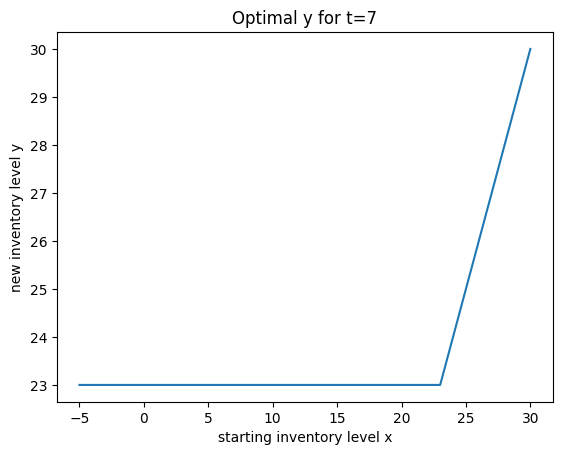

In [3]:
# 1b,c
# Plot the y_t for a specific t over x_range
theta, y_t = get_dp()
for t in range(1, T + 1):
    print(f"S_{t}^*={y_t[t][np.min(x_range)]}")
plt.plot(x_range, [y_t[7][x] for x in x_range])
plt.xlabel("starting inventory level x")
plt.ylabel("new inventory level y")
plt.title("Optimal y for t=7")

1d. Theorize what will happen to the base stock policy if $h_{T +1}$ increase but $p_{T +1}$ remains the same. (You may want to
support your argument with an additional plot, i.e., in the Figure of 1c).


If h_{T+1} increases we will want to keep less stock in the end, as the penalty for overstocking is higher. We can also see this in the figure below.

h_11=1, S_10^*=23
h_11=6, S_10^*=22
h_11=11, S_10^*=21


Text(0.5, 1.0, 'Optimal y for t=10 with different h_{T+1}')

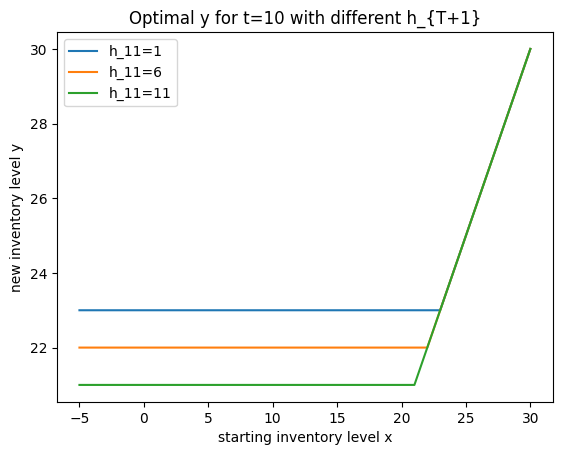

In [8]:
# If h_{T+1} increases we will want to keep less stock in the end, as the penalty for overstocking is higher
theta, y_t = get_dp(h_t_plus_t=2)
for h_t_plus_1 in range(1, 15, 5):
    theta, y_t = get_dp(h_t_plus_t=h_t_plus_1)
    print(f"h_{T+1}={h_t_plus_1}, S_{T}^*={y_t[10][np.min(x_range)]}")
    plt.plot(x_range, [y_t[10][x] for x in x_range], label=f"h_{T+1}={h_t_plus_1}")
plt.legend()
plt.xlabel("starting inventory level x")
plt.ylabel("new inventory level y")
plt.title("Optimal y for t=10 with different h_{T+1}")

S_1^*=23
S_2^*=23
S_3^*=23
S_4^*=23
S_5^*=23
S_6^*=23
S_7^*=23
S_8^*=23
S_9^*=23
S_10^*=23


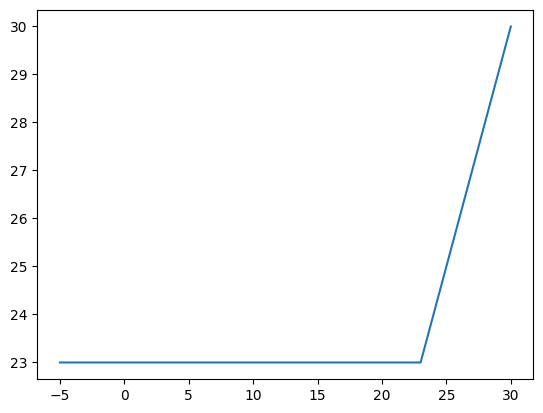

In [5]:
theta, y_t = get_dp(gamma=0.5)
for t in range(1, T + 1):
    print(f"S_{t}^*={y_t[t][np.min(x_range)]}")
plt.plot(x_range, [y_t[7][x] for x in x_range])

# Question 2

2a. Set $h_{T +1} = h$ and $p_{T +1} = p$ and work out the dynamic program. Explain which range of $x$ values you track.


2b. Formulate the optimal $(s, S)-policy$ in each stage, i.e., ($s^{∗}_{t} , S^{∗}_{t}$).

2c. Plot $y_{t}(x)$ for t equals 7.

S*_1 = 11  s*_1 =5
S*_2 = 11  s*_2 =5
S*_3 = 11  s*_3 =5
S*_4 = 11  s*_4 =5
S*_5 = 11  s*_5 =5
S*_6 = 11  s*_6 =5
S*_7 = 11  s*_7 =5
S*_8 = 12  s*_8 =5
S*_9 = 23  s*_9 =7
S*_10= 23  s*_10=17


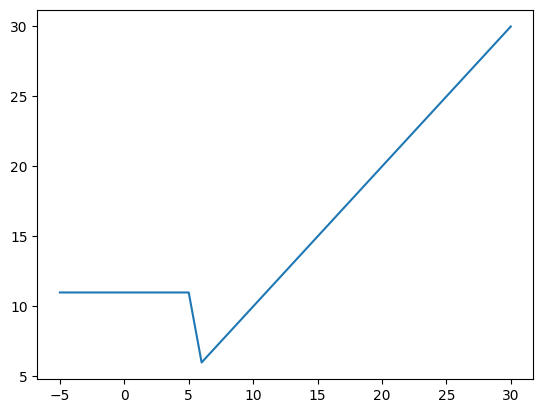

In [ ]:
theta, y_t = get_dp(K=40)
for t in range(1, T + 1):
    S_t = y_t[t][np.min(x_range)]
    # get index of the last element that is equal to S_t
    for x in x_range:
        if y_t[t][x] == S_t:
            s_t = x
        else:
            break
    print(f"S*_{t:<2}={S_t:^4} s*_{t:<2}={s_t}")
plt.plot(x_range, [y_t[7][x] for x in x_range])

plt.xlabel("starting inventory level x")
plt.ylabel("new inventory level y")
plt.title("Optimal y for t=7")

2d. Theorize what will happen to the $(s, S)$ $policies$ if $K$ increase increases and all other costs remain the same. (Again, you may want to support your argument with an additional plot, i.e., in the Figure of 2c).

If K increases we will want to do bigger orders, and fewer orders as the cost of ordering is higher, thus the discontinuity in the graph will move to the left, as we will have a lower $s_t^*$, i.e. the point where we will want to order more.

S*_1 = 11  s*_1 =0
S*_2 = 11  s*_2 =0
S*_3 = 11  s*_3 =0
S*_4 = 11  s*_4 =0
S*_5 = 11  s*_5 =0
S*_6 = 11  s*_6 =0
S*_7 = 11  s*_7 =0
S*_8 = 11  s*_8 =1
S*_9 = 12  s*_9 =1
S*_10= 23  s*_10=10


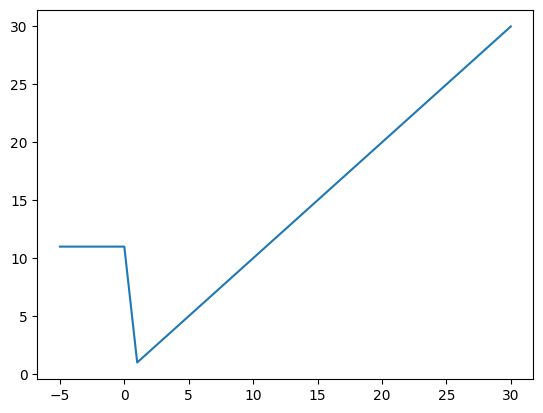

In [7]:
# If K increases we will want to do bigger orders, and fewer orders as the cost of ordering is higher, thus the discontinuity in the graph
# will move to the left, as we will have a lower s*_t, i.e. the point where we will want to order more.

theta, y_t = get_dp(K=80)
for t in range(1, T + 1):
    S_t = y_t[t][np.min(x_range)]
    # get index of the last element that is equal to S_t
    for x in x_range:
        if y_t[t][x] == S_t:
            s_t = x
        else:
            break
    print(f"S*_{t:<2}={S_t:^4} s*_{t:<2}={s_t}")
plt.plot(x_range, [y_t[6][x] for x in x_range])